# Transformer model

In [3]:
# Dependencies
import sys
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import copy
import sklearn.metrics as metrics
# from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
# from torchinfo import summary
import parameters
import random
from data_formatting import split_sequence_overlap, split_sequence_nooverlap, split_sequence, split_train_test, normalize_data, set_targets
parameters.initialize_parameters()
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Architecture

## Pytorch Version

In [4]:
class Transformer(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, seq_length=1000, num_heads=10):
        super(Transformer, self).__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        positions = seq_length + 1 
        # Positional Encoding
        self.position_enc = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(positions, d_hid=100, T=1000), freeze=True) # frozen weight 
        self.mha = []
        self.fc_input_size = 100 * seq_length
        self.relu = nn.ReLU()
        # Dropout
        self.dropout = nn.Dropout(p=0.5)
        # LayerNorm 
        self.layernorm = nn.LayerNorm((1000, 100))
        
        for _ in range(self.num_layers):
            # Multi-head self-attention Layer
            self.mha.append(nn.MultiheadAttention(100, num_heads, batch_first=True)) # (batch, seq, feature)
            # Feed-Forward Network
            # self.encoder.append(nn.Linear(self.fc_input_size, self.fc_input_size))
            
        self.fc1 = nn.Linear(self.fc_input_size, 4096)
        self.fc2 = nn.Linear(4096, 2)
        # self.fc1 = nn.Linear(self.fc_input_size, 4096)
        # self.fc2 = nn.Linear(4096, self.hidden_size)
        # self.fc3 = nn.Linear(self.hidden_size, 2)
    
    def forward(self,x):
        src_pos = torch.arange(0, self.seq_length, dtype=torch.long).expand(x.shape[0], self.seq_length) # (batch_size, seq_length)
        x = x + self.position_enc(src_pos) # (16, 1000, 100)
        for i in range(self.num_layers):
            x2 = self.mha[i](x, x, x)[0] # (query, key, value)
            # residual connection
            x = self.layernorm(x + x2)
            
            #x = x.view(-1, self.fc_input_size) 
            #x = self.relu(self.encoder[2](x))
            #x = self.dropout(x)
            #x = x.view(self.input_size, self.seq_length, 100) 
            
        # x = self.relu(self.fc1(x))
        # x = self.relu(self.fc2(x))
        # x = self.fc3(x)
        x = x.view(-1, self.fc_input_size) 
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Positional Encoding
def get_sinusoid_encoding_table(positions, d_hid, T=1000, cuda=False):
    ''' Sinusoid position encoding table
    positions: int or list of integer, if int range(positions)'''

    if isinstance(positions, int):
        positions = list(range(positions))

    def cal_angle(position, hid_idx):
        return position / np.power(T, 2 * (hid_idx // 2) / d_hid)

    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_hid)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in positions])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return torch.FloatTensor(sinusoid_table)

    # if cuda:
    #     return torch.FloatTensor(sinusoid_table).to('cuda')
    # else:
    #     return torch.FloatTensor(sinusoid_table)

In [9]:
# class Transformer(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers=1, seq_length=1000, num_heads=10):
#         super(Transformer, self).__init__()
#         self.num_layers = num_layers #number of layers
#         self.input_size = input_size #input size
#         self.hidden_size = hidden_size #hidden state
#         self.seq_length = seq_length #sequence length

#         positions = seq_length + 1 
#         # Positional Encoding
#         self.position_enc = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(positions, d_hid=100, T=1000), freeze=True) # frozen weight 
#         # Multi-head self-attention Layer
#         self.mha = []
#         for _ in range(self.num_layers):
#           self.mha.append(nn.MultiheadAttention(100, num_heads, batch_first=True)) # (batch, seq, feature)
#         # Layer normalization
#         self.layernorm = nn.LayerNorm((1000, 100))
        
#         # Feed-Forward Network
#         self.fc_input_size = 100 * seq_length
#         #self.fc = nn.Linear(self.fc_input_size, 2)
#         self.fc1 = nn.Linear(self.fc_input_size, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, 2)
#         self.relu = nn.ReLU()
    
#     def forward(self,x):
#         src_pos = torch.arange(0, self.seq_length, dtype=torch.long).expand(x.shape[0], self.seq_length) # (batch_size, seq_length) = (16, 100)
#         x = x + self.position_enc(src_pos) # (16, 1000, 100)
#         x2 = x
#         for i in range(self.num_layers):
#           x2, _ = self.mha[i](x2, x2, x2) # (query, key, value)
#         # residual connection
#         x = self.layernorm(x + x2)
#         # reshape
#         x = x.view(-1, self.fc_input_size) 
#         #x = self.fc(x)
#         x = self.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# # Positional Encoding
# def get_sinusoid_encoding_table(positions, d_hid, T=1000, cuda=False):
#     ''' Sinusoid position encoding table
#     positions: int or list of integer, if int range(positions)'''

#     if isinstance(positions, int):
#         positions = list(range(positions))

#     def cal_angle(position, hid_idx):
#         return position / np.power(T, 2 * (hid_idx // 2) / d_hid)

#     def get_posi_angle_vec(position):
#         return [cal_angle(position, hid_j) for hid_j in range(d_hid)]

#     sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in positions])

#     sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
#     sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

#     if cuda:
#         return torch.FloatTensor(sinusoid_table).cuda()
#     else:
#         return torch.FloatTensor(sinusoid_table)

# Functions

In [5]:
def validation_accuracy(model, val_loader, nclasses, device, input_dim, error, loss, epoch, test_subj, xv, loss_list, val_loss_list, epoch_list, accuracy_list):
    all_val_predicted = []
    all_val_labels = []
    all_val_outputs = np.empty((0, nclasses), dtype='float')
    correct = 0
    total = 0

    # Iterate through validation dataset
    model.eval()
    with torch.no_grad():
        for features, labels in val_loader:
            features = Variable(features.view(-1, parameters.seq_dim, input_dim)).to(device)
            labels = Variable(labels).to(device)

            # Forward propagation
            outputs = model(features)
            val_loss = error(outputs, labels)

            # Get predictions from the maximum value
            predicted = torch.max(outputs.data, 1)[1]
            predicted = predicted.to('cpu')

            # Total number of labels
            total += labels.size(0)
            correct += (predicted == labels.cpu()).sum()
            all_val_predicted.extend(list(predicted.detach().numpy()))
            all_val_labels.extend(list(labels.cpu().detach().numpy()))
            all_val_outputs = np.concatenate((all_val_outputs, outputs.data.to('cpu').reshape(-1, nclasses)))

    al_np = np.array(all_val_labels)   
    ao_np = np.array(all_val_outputs)  
    accuracy = correct / float(total)

    # store loss and iteration
    loss_list.append(loss.data)
    val_loss_list.append(val_loss.data)
    epoch_list.append(epoch)
    accuracy_list.append(accuracy)
    print('Subject: {}/{}  Epoch: {:>3}  Loss: {:.6}/{:.6}  Validation accuracy: {:.2f}'.format(test_subj, xv, epoch, loss, val_loss, accuracy))
    return accuracy
    
def cross_accuracy(model, test_loader, avg_test_acc, test_acc_list, test_accuracies, nclasses, device, error_cpu, input_dim, features_test, targets_test, error, xv, test_subj):
    
    correct = 0
    total = 0
    prev_label = -1
    class_hist = np.zeros(nclasses, dtype='int')
    all_predicted = []
    all_labels = []
    all_outputs = np.empty((0, nclasses), dtype='float')

    # Iterate through test dataset
    model.eval()
    with torch.no_grad():
        if parameters.test_with_subsequences:
            for features, labels in test_loader:
                features = Variable(features.view(-1, parameters.test_seq_dim, input_dim)).to(device)
                labels = Variable(labels).to('cpu')

                # Forward propagation
                outputs = model(features)
                test_loss = error_cpu(outputs.to('cpu'), labels)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                predicted = predicted.to('cpu')

                # Total number of labels
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_predicted.extend(list(predicted.detach().numpy()))
                all_labels.extend(list(labels.detach().numpy()))
                all_outputs = np.concatenate((all_outputs, outputs.data.to('cpu').reshape(-1, nclasses)))

        
        else:
            count=0
            for features in features_test:
                features = torch.tensor(features)
                features = torch.unsqueeze(features, 0).to(device)
                labels = torch.unsqueeze(torch.tensor(targets_test[count]), 0)
                features = Variable(features.view(-1, parameters.test_seq_dim, input_dim)).to(device)

                # Forward propagation
                outputs = model(features)

                test_loss = error(outputs.to('cpu'), labels)
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                predicted = predicted.to('cpu')

                # Total number of labels
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                count += 1

        al_np = np.array(all_labels)   
        ao_np = np.array(all_outputs)  

        accuracy = correct / float(total)

        print(f"Test accuracy for run {test_subj}/{xv}: {accuracy}")

    avg_test_acc += accuracy
    test_acc_list.append(accuracy)


def train_model(list_labels, list_targets, epochs, learning_rate, weight_decay, device, num_validation_subjects, train_df):
    
    target_1 = list_targets[0]
    target_2 = list_targets[1]

    print(f"Training transformer model for {target_1} and {target_2}...")
    # Select only the classes we want to predict
    train_df, nclasses, targets_numpy = set_targets(train_df, list_targets, list_labels)

    # Convert the subject names (strings) into numbers
    subjects = pd.factorize(train_df['Subject'])[0]

    # Normalise the features
    features_numpy = normalize_data(train_df, False) #parameters.normalise_individual_subjects
    input_dim = features_numpy.shape[1]
    #print(f"Number of features: {input_dim}")
    print(f"Shape of dataset: {features_numpy.shape}")
    
    del train_df
    
    # Variable we will use throughout the training and testing
    test_accuracies = []
    calibrated_test_accuracies = []
    all_outputs = np.empty((0, nclasses), dtype='float')

    # Validation accuracy
    loss_list = []
    val_loss_list = []
    epoch_list = []
    accuracy_list = []

    # Get distinct subjects
    subj = np.unique(subjects)

    # Loop over all subjects
    for test_subj in subj:
        xv_max_val = 0
        avg_test_acc = 0
        val_acc_val_loss_list = []
        test_acc_list = []
        best_accuracy = 0

        file_name = f'../model_transformer/best_model_checkpoint_{target_1}_{target_2}_{test_subj}.pth'

        # Cross validation
        for xv in range(parameters.cross_validation_passes):

            # Set up the train, validation and test sets
            test_idx = np.array([test_subj])

            # Take out test subject from trainval (Crooss validation)
            trainval_idx = np.delete(subj, np.where(subj==test_subj))
            val_idx = trainval_idx[random.sample(range(len(trainval_idx)), num_validation_subjects)]
            val_idx = val_idx%len(subj)

            # Remove test & validation subjects from trainval
            train_idx = np.setxor1d(subj, test_idx)
            train_idx = np.setxor1d(train_idx, val_idx)

            #print("Generating train/val/test split...")
            features_train, targets_train, features_val, targets_val, features_test, targets_test = split_train_test(targets_numpy, features_numpy, subjects, train_idx, val_idx, test_idx)

            #print("Generating sequences...")
            features_train, targets_train = split_sequence_overlap(features_train, targets_train, parameters.seq_dim, parameters.overlap_size)
            features_val, targets_val = split_sequence_overlap(features_val, targets_val, parameters.seq_dim, parameters.overlap_size)
            
            # Overlap or no
            if parameters.test_with_subsequences:
                features_test, targets_test = split_sequence_overlap(features_test, targets_test, parameters.test_seq_dim, parameters.test_overlap_size)
            else:
                features_test, targets_test = split_sequence_nooverlap(features_test, targets_test, parameters.test_seq_dim, parameters.test_overlap_size)

            #print(f"Number of training examples: {len(targets_train)}")
            #print(f"Number of validation examples: {len(targets_val)}")
            #print(f"Number of test examples: {len(targets_test)}")

            # Create feature and targets tensor for train set. We need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
            featuresTrain = torch.from_numpy(features_train)
            targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)  # data type is long

            featuresVal = torch.from_numpy(features_val)
            targetsVal = torch.from_numpy(targets_val).type(torch.LongTensor)  # data type is long

            # Pytorch train and validation sets
            train = TensorDataset(featuresTrain, targetsTrain)
            val = TensorDataset(featuresVal, targetsVal)
            
            
            # Data loader
            train_loader = DataLoader(train, batch_size=parameters.batch_size, shuffle=True)
            val_loader = DataLoader(val, batch_size=parameters.batch_size, shuffle=False)
            

            # Create feature and targets tensor for test set
            if parameters.test_with_subsequences:
                featuresTest = torch.from_numpy(features_test)
                targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)  # data type is long
                test = TensorDataset(featuresTest, targetsTest)
                test_loader = DataLoader(test, batch_size=parameters.batch_size, shuffle=False)
            
            # Model
            model = Transformer(parameters.batch_size, parameters.hidden_dim).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            error = nn.CrossEntropyLoss()
            error_cpu = nn.CrossEntropyLoss().to(device) # 'cpu'

            # Early Stopping
            
            patience = epochs -1
            #patience = 4
            current_patience = 0

            # Train the model
            for epoch in range(epochs):
                model.train()
                running_loss = 0
                for data, target in train_loader:
                    data, target = data.to(device), target.to(device)
                    # print(data.shape)
                    optimizer.zero_grad()
                    outputs = model(data)
                    loss = error(outputs, target)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()

                # Validation accuracy
                accuracy = validation_accuracy(model, val_loader, nclasses, device, input_dim, error, loss, epoch, test_subj, xv, loss_list, val_loss_list, epoch_list, accuracy_list)

                ### Early stopping
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    torch.save(model.state_dict(), file_name)
                    current_patience = 0  # Reset patience counter
                else:
                    current_patience += 1  # No improvement, increase patience counter
                
                if current_patience >= patience:
                    # Early stopping condition met
                    #print(f'Early stopping at epoch {epoch} due to lack of improvement.')
                    break

            # Restore the best model checkpoint
            model.load_state_dict(torch.load(file_name))
        
            # Cross validation accuracy
            cross_accuracy(model, test_loader, avg_test_acc, test_acc_list, test_accuracies, nclasses, device, error_cpu, input_dim, features_test, targets_test, error, xv, test_subj)

        avg_test_acc = np.mean(test_acc_list)
        test_accuracies.append(avg_test_acc)
    
    print("Test accuracies:")
    print(test_accuracies)
    mean_accuracy = np.mean(test_accuracies)
    print(f"Mean accuracy: {mean_accuracy}")
    return mean_accuracy

In [22]:
def train_model_for_specific_test_subj(list_labels, list_targets, epochs, learning_rate, weight_decay, device, num_validation_subjects, train_df, test_subj):
    
    target_1 = list_targets[0]
    target_2 = list_targets[1]

    print(f"Training transformer model for {target_1} and {target_2}...")
    # Select only the classes we want to predict
    train_df, nclasses, targets_numpy = set_targets(train_df, list_targets, list_labels)

    # Convert the subject names (strings) into numbers
    subjects = pd.factorize(train_df['Subject'])[0]

    # Normalise the features
    features_numpy = normalize_data(train_df, False) #parameters.normalise_individual_subjects
    input_dim = features_numpy.shape[1]
    #print(f"Number of features: {input_dim}")
    print(f"Shape of dataset: {features_numpy.shape}")
    
    del train_df
    
    # Variable we will use throughout the training and testing
    test_accuracies = []
    calibrated_test_accuracies = []
    all_outputs = np.empty((0, nclasses), dtype='float')

    # Validation accuracy
    loss_list = []
    val_loss_list = []
    epoch_list = []
    accuracy_list = []

    file_name = f'../model_transformer/best_model_checkpoint_{target_1}_{target_2}_{test_subj}.pth'

    # Get distinct subjects
    subj = np.unique(subjects)

    xv_max_val = 0
    avg_test_acc = 0
    val_acc_val_loss_list = []
    test_acc_list = []
    best_accuracy = 0


    # Cross validation
    for xv in range(parameters.cross_validation_passes):

        # Set up the train, validation and test sets
        test_idx = np.array([test_subj])

        # Take out test subject from trainval (Crooss validation)
        trainval_idx = np.delete(subj, np.where(subj==test_subj))
        val_idx = trainval_idx[random.sample(range(len(trainval_idx)), num_validation_subjects)]
        val_idx = val_idx%len(subj)

        # Remove test & validation subjects from trainval
        train_idx = np.setxor1d(subj, test_idx)
        train_idx = np.setxor1d(train_idx, val_idx)

        #print("Generating train/val/test split...")
        features_train, targets_train, features_val, targets_val, features_test, targets_test = split_train_test(targets_numpy, features_numpy, subjects, train_idx, val_idx, test_idx)

        #print("Generating sequences...")
        features_train, targets_train = split_sequence_overlap(features_train, targets_train, parameters.seq_dim, parameters.overlap_size)
        features_val, targets_val = split_sequence_overlap(features_val, targets_val, parameters.seq_dim, parameters.overlap_size)
        
        # Overlap or no
        if parameters.test_with_subsequences:
            features_test, targets_test = split_sequence_overlap(features_test, targets_test, parameters.test_seq_dim, parameters.test_overlap_size)
        else:
            features_test, targets_test = split_sequence_nooverlap(features_test, targets_test, parameters.test_seq_dim, parameters.test_overlap_size)

        #print(f"Number of training examples: {len(targets_train)}")
        #print(f"Number of validation examples: {len(targets_val)}")
        #print(f"Number of test examples: {len(targets_test)}")

        # Create feature and targets tensor for train set. We need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
        featuresTrain = torch.from_numpy(features_train)
        targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)  # data type is long

        featuresVal = torch.from_numpy(features_val)
        targetsVal = torch.from_numpy(targets_val).type(torch.LongTensor)  # data type is long

        # Pytorch train and validation sets
        train = TensorDataset(featuresTrain, targetsTrain)
        val = TensorDataset(featuresVal, targetsVal)
        
        
        # Data loader
        train_loader = DataLoader(train, batch_size=parameters.batch_size, shuffle=True)
        val_loader = DataLoader(val, batch_size=parameters.batch_size, shuffle=False)
        

        # Create feature and targets tensor for test set
        if parameters.test_with_subsequences:
            featuresTest = torch.from_numpy(features_test)
            targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)  # data type is long
            test = TensorDataset(featuresTest, targetsTest)
            test_loader = DataLoader(test, batch_size=parameters.batch_size, shuffle=False)
        
        # Model
        model = Transformer(parameters.batch_size, parameters.hidden_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        error = nn.CrossEntropyLoss()
        error_cpu = nn.CrossEntropyLoss().to(device) # 'cpu'

        # Early Stopping
        
        patience = epochs -1
        #patience = 4
        current_patience = 0

        # Train the model
        for epoch in range(epochs):
            model.train()
            running_loss = 0
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                # print(data.shape)
                optimizer.zero_grad()
                outputs = model(data)
                loss = error(outputs, target)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            # Validation accuracy
            accuracy = validation_accuracy(model, val_loader, nclasses, device, input_dim, error, loss, epoch, test_subj, xv, loss_list, val_loss_list, epoch_list, accuracy_list)

            ### Early stopping
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                torch.save(model.state_dict(), file_name)
                current_patience = 0  # Reset patience counter
            else:
                current_patience += 1  # No improvement, increase patience counter
            
            if current_patience >= patience:
                # Early stopping condition met
                #print(f'Early stopping at epoch {epoch} due to lack of improvement.')
                break

        # Restore the best model checkpoint
        model.load_state_dict(torch.load(file_name))
    
        # Cross validation accuracy
        cross_accuracy(model, test_loader, avg_test_acc, test_acc_list, test_accuracies, nclasses, device, error_cpu, input_dim, features_test, targets_test, error, xv, test_subj)

    avg_test_acc = np.mean(test_acc_list)
    test_accuracies.append(avg_test_acc)
    
    print("Test accuracies:")
    print(test_accuracies)
    mean_accuracy = np.mean(test_accuracies)
    print(f"Mean accuracy: {mean_accuracy}")
    return mean_accuracy

# Parameter

In [6]:
# Classes we want to predict (0 et 3) and binary outputs
list_targets = [0, 3]
list_labels = [0, 1]

# number of subjects used for validation
num_validation_subjects = 1

learning_rate = 0.0007
weight_decay = 10e-4
epochs = 3

print(torch.__version__)
device = torch.device('cpu')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using {device}")

2.1.2+cu121


In [23]:
# Get data
csvfile = "../../data/video/All_Subs_Diff_Modules_nofilter_withoutAUc.csv"
train_df = pd.read_csv(csvfile,  delimiter=",")  # 101 features (only AU_r)

# Create folder to save models
if not os.path.exists("../model_transformer/"):
    os.makedirs("../model_transformer/")


results_dict = {}

In [27]:
# train all models
for i in range(6):
    for j in range(i+1, 6):
        list_targets = [i, j]
        accuracy = train_model_for_specific_test_subj(list_labels,list_targets, epochs, learning_rate, weight_decay, device, num_validation_subjects, train_df,3)
        results_dict[tuple(list_targets)] = accuracy

print(results_dict)

Training transformer model for 0 and 1...
Shape of dataset: (221004, 100)
Subject: 2/0  Epoch:   0  Loss: 0.376898/0.0673712  Validation accuracy: 0.56
Subject: 2/0  Epoch:   1  Loss: 0.399972/4.95734  Validation accuracy: 0.51
Subject: 2/0  Epoch:   2  Loss: 0.301656/0.754184  Validation accuracy: 0.67
Test accuracy for run 2/0: 0.6109422492401215
Subject: 2/1  Epoch:   0  Loss: 0.989251/4.07151  Validation accuracy: 0.42
Subject: 2/1  Epoch:   1  Loss: 0.282568/4.24717  Validation accuracy: 0.45
Test accuracy for run 2/1: 0.6398176291793313
Subject: 2/2  Epoch:   0  Loss: 0.364745/0.0348898  Validation accuracy: 1.00
Subject: 2/2  Epoch:   1  Loss: 0.41369/0.0380064  Validation accuracy: 0.99
Subject: 2/2  Epoch:   2  Loss: 0.00415179/0.000505541  Validation accuracy: 0.96
Test accuracy for run 2/2: 0.5729483282674772
Test accuracies:
[0.60790273556231]
Mean accuracy: 0.60790273556231
Training transformer model for 0 and 2...
Shape of dataset: (220827, 100)
Subject: 2/0  Epoch:   0  

In [30]:
import csv
# Specify the CSV file path
csv_file_path = '../model_transformer/results.csv'

# Open the CSV file in write mode
with open(csv_file_path, 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the header (assuming your CSV should have columns "Targets" and "Accuracy")
    csv_writer.writerow(['Targets', 'Accuracy'])

    # Write each row in the dictionary to the CSV file
    for targets, accuracy in results_dict.items():
        # Convert the tuple of lists to a string for easy representation in CSV
        targets_str = ', '.join(map(str, targets))
        csv_writer.writerow([targets_str, accuracy])

In [21]:
# 0: SelfStim
# 1: CtrlStim
# 2: SelfRest
# 3: CtrlRest
# 4: SelfSoc
# 5: CtrlSoc


# train all models
for i in range(6):
    for j in range(i+1, 6):
        list_targets = [i, j]
        accuracy = train_model(list_labels,list_targets, epochs, learning_rate, weight_decay, device, num_validation_subjects, train_df)
        results_dict[tuple(list_targets)] = accuracy

print(results_dict)

Training transformer model for 0 and 1...
Shape of dataset: (221004, 100)
Subject: 0/0  Epoch:   0  Loss: 0.550789/0.542654  Validation accuracy: 0.59
Subject: 0/0  Epoch:   1  Loss: 0.162036/2.45319  Validation accuracy: 0.61
Subject: 0/0  Epoch:   2  Loss: 0.248414/2.03016  Validation accuracy: 0.63
Test accuracy for run 0/0: 0.5886736214605067
Subject: 0/1  Epoch:   0  Loss: 2.16938/6.52067e-06  Validation accuracy: 0.91
Subject: 0/1  Epoch:   1  Loss: 0.0244382/0.153086  Validation accuracy: 0.89
Subject: 0/1  Epoch:   2  Loss: 0.374548/0.00167039  Validation accuracy: 0.93
Test accuracy for run 0/1: 0.5141579731743666
Subject: 0/2  Epoch:   0  Loss: 0.00199405/3.58995  Validation accuracy: 0.58
Subject: 0/2  Epoch:   1  Loss: 0.000936904/0.953114  Validation accuracy: 0.77
Test accuracy for run 0/2: 0.5424739195230999
Subject: 1/0  Epoch:   0  Loss: 0.716223/0.912724  Validation accuracy: 0.70
Subject: 1/0  Epoch:   1  Loss: 0.249753/3.01613  Validation accuracy: 0.57
Subject: 1/0

KeyboardInterrupt: 

ValueError: input operand has more dimensions than allowed by the axis remapping

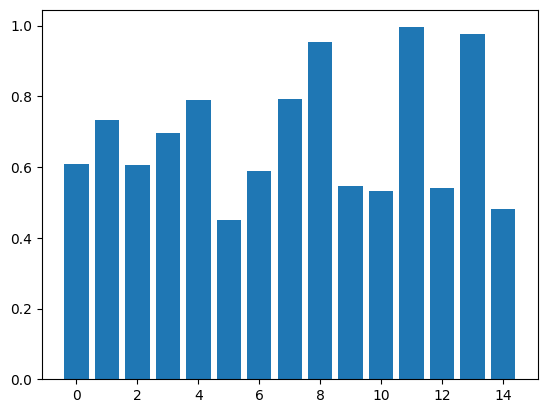

In [28]:
# Mapping between digits and their names
label_mapping = {
    0: 'SelfStim',
    1: 'CtrlStim',
    2: 'SelfRest',
    3: 'CtrlRest',
    4: 'SelfSoc',
    5: 'CtrlSoc'
}

# Replace the digits with their names in list_targets
#list_targets_names = [(label_mapping[i], label_mapping[j]) for i, j in results_dict.keys()]

# Extract the list of list_targets and accuracy values
list_targets, accuracies = zip(*results_dict.items())

# Create a bar plot
plt.bar(range(len(list_targets)), accuracies, tick_label=list_targets)
plt.xlabel('List Targets')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different List Targets')
plt.show()

# Training

In [ ]:
list_targets = [0, 4]

In [ ]:
# Get data
csvfile = "../../data/video/All_Subs_Diff_Modules_nofilter_withoutAUc.csv"
train_df = pd.read_csv(csvfile,  delimiter=",")  # 101 features (only AU_r)

# Select only the classes we want to predict
train_df, nclasses, targets_numpy = set_targets(train_df, list_targets, list_labels)

# Convert the subject names (strings) into numbers
subjects = pd.factorize(train_df['Subject'])[0]

# Normalise the features
features_numpy = normalize_data(train_df, False) #parameters.normalise_individual_subjects
input_dim = features_numpy.shape[1]
print(f"Number of features: {input_dim}")
print(f"Shape of dataset: {features_numpy.shape}")

del train_df

In [ ]:
# Variable we will use throughout the training and testing
test_accuracies = []
calibrated_test_accuracies = []
all_outputs = np.empty((0, nclasses), dtype='float')

# Create folder to save models
if not os.path.exists("../model_transformer/"):
    os.makedirs("../model_transformer/")

# Validation accuracy
loss_list = []
val_loss_list = []
epoch_list = []
accuracy_list = []

# Get distinct subjects
subj = np.unique(subjects)

# Loop over all subjects
for test_subj in subj:
    xv_max_val = 0
    avg_test_acc = 0
    val_acc_val_loss_list = []
    test_acc_list = []
    best_accuracy = 0
    file_name = f'../model_cnn/best_model_checkpoint_{list_targets[0]}_{list_targets[1]}_{test_subj}.pth'

    # Cross validation
    for xv in range(parameters.cross_validation_passes):

        # Set up the train, validation and test sets
        test_idx = np.array([test_subj])

        # Take out test subject from trainval (Crooss validation)
        trainval_idx = np.delete(subj, np.where(subj==test_subj))
        val_idx = trainval_idx[random.sample(range(len(trainval_idx)), num_validation_subjects)]
        val_idx = val_idx%len(subj)

        # Remove test & validation subjects from trainval
        train_idx = np.setxor1d(subj, test_idx)
        train_idx = np.setxor1d(train_idx, val_idx)

        #print("Generating train/val/test split...")
        features_train, targets_train, features_val, targets_val, features_test, targets_test = split_train_test(targets_numpy, features_numpy, subjects, train_idx, val_idx, test_idx)

        #print("Generating sequences...")
        features_train, targets_train = split_sequence_overlap(features_train, targets_train, parameters.seq_dim, parameters.overlap_size)
        features_val, targets_val = split_sequence_overlap(features_val, targets_val, parameters.seq_dim, parameters.overlap_size)
        
        # Overlap or no
        if parameters.test_with_subsequences:
            features_test, targets_test = split_sequence_overlap(features_test, targets_test, parameters.test_seq_dim, parameters.test_overlap_size)
        else:
            features_test, targets_test = split_sequence_nooverlap(features_test, targets_test, parameters.test_seq_dim, parameters.test_overlap_size)

        #print(f"Number of training examples: {len(targets_train)}")
        #print(f"Number of validation examples: {len(targets_val)}")
        #print(f"Number of test examples: {len(targets_test)}")

        # Create feature and targets tensor for train set. We need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
        featuresTrain = torch.from_numpy(features_train)
        targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)  # data type is long

        featuresVal = torch.from_numpy(features_val)
        targetsVal = torch.from_numpy(targets_val).type(torch.LongTensor)  # data type is long

        # Pytorch train and validation sets
        train = TensorDataset(featuresTrain, targetsTrain)
        val = TensorDataset(featuresVal, targetsVal)
        
        # Data loader
        train_loader = DataLoader(train, batch_size=parameters.batch_size, shuffle=True)
        val_loader = DataLoader(val, batch_size=parameters.batch_size, shuffle=False)

        # Create feature and targets tensor for test set
        if parameters.test_with_subsequences:
            featuresTest = torch.from_numpy(features_test)
            targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)  # data type is long
            test = TensorDataset(featuresTest, targetsTest)
            test_loader = DataLoader(test, batch_size=parameters.batch_size, shuffle=False)
        
        # Model
        model = Transformer(parameters.batch_size, 64).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        error = nn.CrossEntropyLoss()
        error_cpu = nn.CrossEntropyLoss().to('cpu')

        # Early Stopping
        
        patience = epochs -1
        #patience = 4
        current_patience = 0

        # Train the model
        for epoch in range(epochs):
            model.train()
            running_loss = 0
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                loss = error(outputs, target)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            # Validation accuracy
            accuracy = validation_accuracy(model, val_loader, nclasses, device, input_dim, error, loss, epoch, test_subj, xv, loss_list, val_loss_list, epoch_list, accuracy_list)

            ### Early stopping
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                torch.save(model.state_dict(), file_name)
                current_patience = 0  # Reset patience counter
            else:
                current_patience += 1  # No improvement, increase patience counter
            
            if current_patience >= patience:
                # Early stopping condition met
                print(f'Early stopping at epoch {epoch} due to lack of improvement.')
                break

        # Restore the best model checkpoint
        model.load_state_dict(torch.load(file_name))
    
        # Cross validation accuracy
        cross_accuracy(model, test_loader, avg_test_acc, test_acc_list, test_accuracies, nclasses, device, error_cpu, input_dim, features_test, targets_test, error, xv, test_subj)

    avg_test_acc = np.mean(test_acc_list)
    test_accuracies.append(avg_test_acc)
  
print("Test accuracies:")
print(test_accuracies)
print(f"Mean accuracy: {np.mean(test_accuracies)}")

In [ ]:
# save the model
PATH = './tr_model_0_3.pth'
torch.save(model.state_dict(), PATH)

## Another Version

In [ ]:
# Positional Encoding => keep position's information
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        # self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div)
        pe[:, 1::2] = torch.cos(position * div)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe) # store "pe" without gradient update

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x # self.dropout(x)

In [ ]:
# Encoder => compute a rich representation of sequence
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=500, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead) # , dropout=dropout
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x2 = self.self_attn(x, x, x)[0]
        x = x + self.dropout1(x2)
        x = self.norm1(x)
        x2 = self.linear2(self.dropout(self.linear1(x)))
        x = x + self.dropout2(x2)
        x = self.norm2(x)
        return x

In [ ]:
# Classifier replace Decoder => decision instead of generation
class TransformerClassifier(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward, num_classes, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.encoder_layer = TransformerEncoder(d_model, nhead, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers)
        self.classifier = nn.Linear(d_model, num_classes)
        self.pos_encoder = PositionalEncoding(d_model, dropout)

    def forward(self, x):
        x = self.pos_encoder(x)
        output = self.transformer_encoder(x)
        output = self.classifier(output[:, -1, :])
        return output

In [ ]:
# Hyperparameters
d_model = 1
nhead = 10
num_layers = 2
dim_feedforward = 500
num_classes = 2
dropout = 0.1
# Create the model
model = TransformerClassifier(d_model, nhead, num_layers, dim_feedforward, num_classes, dropout)

# END